In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.ndimage import label
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

MAX_STEPS = 10

def generate_percolation_lattice(size, p):
    return np.random.choice([0, 1], (size, size), p=[1-p, p]).astype(np.uint8)

def check_percolation(lattice):
    labeled, _ = label(lattice)
    top = set(labeled[0]) - {0}
    bottom = set(labeled[-1]) - {0}
    left = set(labeled[:,0]) - {0}
    right = set(labeled[:,-1]) - {0}
    return float(bool(top & bottom) or bool(left & right))

def first_coarse_graining(binary_lattice, dim):
    """Average non-overlapping dim×dim blocks."""
    t = torch.tensor(binary_lattice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    patches = F.unfold(t, kernel_size=dim, stride=dim)             # [1, dim*dim, num_patches]
    patches = patches.permute(0, 2, 1)                             # [1, num_patches, dim*dim]
    coarse_vals = patches.mean(dim=2)                             # [1, num_patches]
    H, W = binary_lattice.shape
    new_h, new_w = H // dim, W // dim
    return coarse_vals.view(1, 1, new_h, new_w).squeeze(0)        # [1, new_h, new_w]

class PercolationModel(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.rule = nn.Sequential(
            nn.Linear(dim * dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, max_steps=MAX_STEPS):
        b, c, H, W = x.shape
        for _ in range(max_steps):
            if H < self.dim or W < self.dim:
                break
            patches = F.unfold(x, kernel_size=self.dim, stride=self.dim)  # [b, dim*dim, np]
            patches = patches.permute(0, 2, 1).contiguous()               # [b, np, dim*dim]
            out = self.rule(patches.view(-1, self.dim*self.dim))          # [b*np, 1]
            new_h, new_w = H // self.dim, W // self.dim
            x = out.view(b, 1, new_h, new_w)
            _, _, H, W = x.shape
        return x.squeeze(1).view(b, -1)  # returns shape [b, new_h*new_w] or [b] if fully reduced

def prepare_dataset(N, sizes):
    data = []
    for _ in tqdm(range(N), desc="Generating data"):
        p = np.random.uniform(0.1, 0.9)
        size = np.random.choice(sizes)
        L = generate_percolation_lattice(size, p)
        data.append((L, check_percolation(L)))
    return data

def train_epoch(model, device, data, batch_size, opt, crit):
    model.train()
    total_loss = 0.0
    # Process in batches, then split into size groups
    for i in tqdm(range(0, len(data), batch_size), desc="Training"):
        batch = data[i:i+batch_size]
        processed = []
        # Apply first_coarse_graining and get sizes
        for x, y in batch:
            cg_lattice = first_coarse_graining(x, DIM)  # [1, H', W']
            h, w = cg_lattice.shape[-2], cg_lattice.shape[-1]
            processed.append((cg_lattice, y, (h, w)))
        
        # Group by size
        groups = {}
        for cg, y, size in processed:
            if size not in groups:
                groups[size] = []
            groups[size].append((cg, y))
        
        # Process each group
        group_loss = 0.0
        for size_key, group in groups.items():
            lattices = [item[0] for item in group]
            labels = [item[1] for item in group]
            inputs = torch.stack(lattices).to(device)  # [B, 1, H, W]
            targets = torch.tensor(labels, dtype=torch.float32, device=device)
            
            opt.zero_grad()
            outputs = model(inputs)  # [B, 1]
            loss = crit(outputs.view(-1), targets)
            loss.backward()
            opt.step()
            group_loss += loss.item() * len(group)
        
        total_loss += group_loss
    
    return total_loss / len(data)

def test_systems(model, dim, power, device='cpu',
                              num_tests=50, system_size='standard',
                              p_range=(0,1), verbose=True):
    """
    For each test:
      1) generate a raw DIM^size_power × DIM^size_power lattice
      2) compute true percolation label on that raw lattice
      3) manually coarse-grain once (patch size = dim)
      4) feed the result into model (which will do further recursive steps)
    """
    model.to(device).eval()

    # Determine the exponent for lattice_size
    size_power = {'3^2': power-1, '3^3': power, '3^4': power+1, '3^5': power+2, '3^6': power+3, '3^7': power+4}[system_size]
    L = dim ** size_power

    results = []
    for _ in tqdm(range(num_tests), desc=f"Testing {L}×{L}"):
        # 1) Raw lattice + label
        p   = np.random.uniform(*p_range)
        raw = generate_percolation_lattice(L, p)
        lbl = check_percolation(raw)

        # 2) Manual first coarse-graining
        coarse = first_coarse_graining(raw, dim)   # tensor shape [1, L/dim, L/dim]

        # 3) Prepare input for the model
        inp = coarse.unsqueeze(0).to(device)       # [1, 1, L/dim, L/dim]

        # 4) Get network prediction
        with torch.no_grad():
            # Let the model do its remaining recursion as usual
            # (the `max_steps` is large enough that it will recurse until <dim)
            out = model(inp).view(-1).item()

        results.append((raw, lbl, out))

    # Compute accuracy at 0.5 threshold
    acc = sum((pred > 0.5) == lbl for _, lbl, pred in results) / num_tests

    if verbose:
        pos = [pred for _, lbl, pred in results if lbl==1]
        neg = [pred for _, lbl, pred in results if lbl==0]
        print(f"\nAfter manual first coarse-grain -> NN cascade on {L}×{L}:")
        print(f" Accuracy        : {acc:.2%}")
        print(f" Avg pred | Perc     : {np.mean(pos):.3f}")
        print(f" Avg pred | Non-Perc : {np.mean(neg):.3f}")

    return results


In [2]:
# ----------------- Run -----------------
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Add this configuration block (critical for model initialization)
DIM = 3      # Patch size for coarse-graining (fixed for the model architecture)
POWER = 3    # Base exponent for lattice sizes (3^POWER = 27x27 as "standard")
SIZES = [DIM**2, DIM**3, DIM**4]  # Mixed training sizes: 9x9, 27x27, 81x81

# Generate mixed-size training data
train_data = prepare_dataset(20_000, SIZES)

# Initialize model with DIM=3 (matches patch size used in first_coarse_graining)
model = PercolationModel(DIM).to(DEVICE)
opt = optim.Adam(model.parameters(), lr=1e-3)
crit = nn.BCELoss()

# Training loop (unchanged)
for epoch in range(1, 6):
    loss = train_epoch(model, DEVICE, train_data, 10, opt, crit)
    print(f"Epoch {epoch} — Loss: {loss:.4f}")

Training: 100%|████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 244.06it/s]


Epoch 1 — Loss: 0.1692


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 240.02it/s]


Epoch 2 — Loss: 0.1214


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 224.48it/s]


Epoch 3 — Loss: 0.1188


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 222.73it/s]


Epoch 4 — Loss: 0.1160


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 217.78it/s]

Epoch 5 — Loss: 0.1146


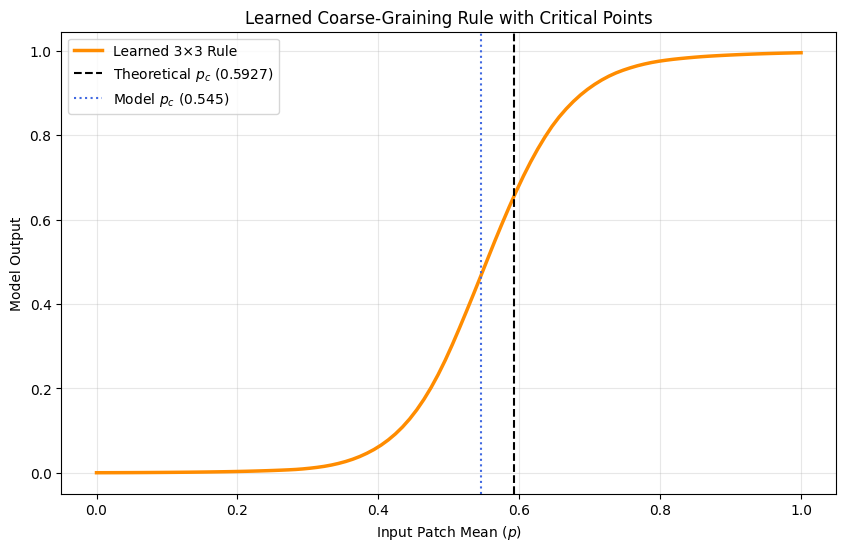

In [3]:
def visualize_rule(model, dim, device='cpu', num_samples=1000):
    """Visualize the learned rule for dim×dim patches with critical points"""
    import matplotlib.pyplot as plt
    from scipy.ndimage import gaussian_filter1d  # For smoothing if needed
    
    p_values = np.linspace(0, 1, 100)
    model.eval()
    mean_outputs = []

    with torch.no_grad():
        for p in p_values:
            inputs = torch.full((num_samples, dim*dim), p, 
                               dtype=torch.float32, device=device)
            outputs = model.rule(inputs).cpu().numpy()
            mean_outputs.append(outputs.mean())
    
    # Calculate derivatives to find concavity change
    first_deriv = np.gradient(mean_outputs)
    second_deriv = np.gradient(first_deriv)
    
    # Find point where second derivative crosses zero (maximum curvature)
    # Smooth derivatives if noisy (optional)
    # second_deriv = gaussian_filter1d(second_deriv, sigma=1)
    zero_crossings = np.where(np.diff(np.sign(second_deriv)))[0]
    
    if len(zero_crossings) > 0:
        # Take last crossing for percolation threshold
        crit_idx = zero_crossings[np.argmax(p_values[zero_crossings])]  
        p_c_model = p_values[crit_idx]
    else:
        p_c_model = p_values[np.argmin(np.abs(second_deriv))]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(p_values, mean_outputs, color='darkorange', linewidth=2.5,
            label=f'Learned {dim}×{dim} Rule')
    
    # Theoretical critical point
    plt.axvline(0.5927, color='black', linestyle='--', 
               label='Theoretical $p_c$ (0.5927)')
    
    # Model-predicted critical point
    plt.axvline(p_c_model, color='royalblue', linestyle=':',
               label=f'Model $p_c$ ({p_c_model:.3f})')
    
    plt.xlabel('Input Patch Mean ($p$)')
    plt.ylabel('Model Output')
    plt.title(f'Learned Coarse-Graining Rule with Critical Points')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'Learned_{dim}x{dim}_Rule_with_crit_points.pdf', bbox_inches='tight')
    plt.show()

# Usage
visualize_rule(model, DIM, DEVICE)

In [4]:
# ----------------- Testing & Reporting -----------------
def run_experiment(model, device):
    """Run all test configurations on a single trained model"""
    test_configs = [
        {'system_size': '3^2', 'num_tests': 100, 'p_range': (0.1, 0.9)},
        {'system_size': '3^3', 'num_tests': 100, 'p_range': (0.1, 0.9)},
        {'system_size': '3^4', 'num_tests': 100, 'p_range': (0.1, 0.9)},
        {'system_size': '3^5', 'num_tests': 100, 'p_range': (0.1, 0.9)},
        {'system_size': '3^6', 'num_tests': 50, 'p_range': (0.1, 0.9)},
        {'system_size': '3^7', 'num_tests': 10, 'p_range': (0.1, 0.9)},
        {'system_size': '3^3', 'num_tests': 200, 'p_range': (0.5, 0.7)}
    ]
    
    test_results = {}
    for config in test_configs:
        key = f"{config['system_size']}_{config['p_range'][0]}-{config['p_range'][1]}"
        test_results[key] = test_systems(
            model=model,
            dim=DIM,         # Use fixed DIM from training
            power=POWER,     # Use fixed POWER from training
            device=device,
            **config
        )

    # Generate plot data using the model's rule
    ps = np.linspace(0.0, 1.0, 101)
    n_patches = 1000
    mean_outputs = []
    
    with torch.no_grad():
        for p in ps:
            # Create random patches matching the model's expected input dimension
            patches = np.random.rand(n_patches, DIM*DIM)  # [num_patches, dim²]
            inp = torch.from_numpy(patches.astype(np.float32)).to(device)
            outs = model.rule(inp).cpu().numpy().flatten()
            mean_outputs.append(outs.mean())
    
    return test_results, (ps, mean_outputs)

# Generate consolidated reports for the single model
def generate_reports(test_results):
    # Text Report
    with open('mixed_size_accuracies.txt', 'w') as f:
        f.write("="*40 + "\nMixed Size Model Performance\n" + "="*40 + "\n")
        
        for key, results in test_results.items():
            acc = sum((pred > 0.5) == lbl for _, lbl, pred in results)/len(results)
            pos = [pred for _, lbl, pred in results if lbl==1]
            neg = [pred for _, lbl, pred in results if lbl==0]
            
            f.write(f"\nTest Config: {key}\n")
            f.write(f"Accuracy: {acc:.2%}\n")
            f.write(f"Avg Perc Pred: {np.mean(pos):.3f}\n")
            f.write(f"Avg Non-Perc Pred: {np.mean(neg):.3f}\n")

# ----------------- Main Execution -----------------
# After training (5 epochs in original code), run:
test_results, plot_data = run_experiment(model, DEVICE)
generate_reports(test_results)

Testing 9×9: 100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2371.08it/s]



After manual first coarse-grain -> NN cascade on 9×9:
 Accuracy        : 98.00%
 Avg pred | Perc     : 0.895
 Avg pred | Non-Perc : 0.083


Testing 27×27: 100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1879.07it/s]



After manual first coarse-grain -> NN cascade on 27×27:
 Accuracy        : 95.00%
 Avg pred | Perc     : 0.907
 Avg pred | Non-Perc : 0.031


Testing 81×81: 100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1363.32it/s]



After manual first coarse-grain -> NN cascade on 81×81:
 Accuracy        : 97.00%
 Avg pred | Perc     : 0.965
 Avg pred | Non-Perc : 0.023


Testing 243×243: 100%|███████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 365.62it/s]



After manual first coarse-grain -> NN cascade on 243×243:
 Accuracy        : 99.00%
 Avg pred | Perc     : 0.996
 Avg pred | Non-Perc : 0.021


Testing 729×729: 100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.78it/s]



After manual first coarse-grain -> NN cascade on 729×729:
 Accuracy        : 99.00%
 Avg pred | Perc     : 0.996
 Avg pred | Non-Perc : 0.015


Testing 2187×2187: 100%|████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.55it/s]



After manual first coarse-grain -> NN cascade on 2187×2187:
 Accuracy        : 98.00%
 Avg pred | Perc     : 0.996
 Avg pred | Non-Perc : 0.035


Testing 27×27: 100%|████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1765.86it/s]


After manual first coarse-grain -> NN cascade on 27×27:
 Accuracy        : 81.50%
 Avg pred | Perc     : 0.813
 Avg pred | Non-Perc : 0.249
